# Poultry Production in Africa Analysis

# Executive Summary

### Context:
Poultry is one of Africa’s fastest-growing livestock sectors but growth raises questions about prices, efficiency and sustainability.

### Goal: 
The goal of this project is to analyze production, prices and agricultural CO₂ emissions (2000-2021), to understand trends, leading countries and relationships between production growth, market prices and environmental impact.

### Approach: 
I acquired and cleaned FAOSTAT data, aggregated to country-year level, applied correlations, lag analysis and efficiency ratios.

### Key Questions:

**Trends**

- How did poultry production change in Africa (2000-2021)?

- What happened to producer prices and emissions over the same period?

**Comparisons**

- Which countries led in eggs and chicken meat output?

- Who grew fastest and how do prices differ across countries?

**Relationships**

- Does higher production drive higher emissions?

- Do prices influence production volumes?

- Which countries are most efficient (output per unit of CO₂)

### Key Findings:

- Poultry production rose steadily, with **South Africa, Egypt and Nigeria** driving most of the growth.

- Producer prices show **volatility**, with variation across markets.

- Raw correlations suggest production and emissions rise together, but within-country analysis highlights efficiency differences.

- Lagged checks show weak but visible price-production responses.

- Efficiency rankings reveal **DRC** as a leader and **Sudan** as a laggard.

**Implications**: The insights are useful for agribusiness to inform agribusiness investment decisions, ESG to  highlight efficiency and sustainability challenges across African poultry farming and policy to benchmark efficiency, anticipate supply responses and target support for low-efficiency producers.

### Data & Scope

Source: FAOSTAT datasets (Production, Producer Prices, Emissions).

Coverage: Africa, 2000-2021, aggregated to country-year panel.

**Units:**

Production = tonnes

Prices = USD per tonne

Emissions = kilotonnes (kt CO₂e), converted to kg where needed

**Focus:** Eggs + chicken meat (summed for totals).

This project demonstrates skills in data cleaning, exploratory data analysis, visualization and joins.

**Limitations:** Missing years for some countries, no imputation, analysis focuses on correlations and ratios, not causal models and inavailabilty of poultry-specific poultry emissions data.


# Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sanity Checks and Preprocessing

## Production Dataset

In [2]:
df1=pd.read_csv("FAOSTAT_poultry_production.csv.csv")
print("Shape:", df1.shape)
df1.head()

Shape: (6290, 15)


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,12,Algeria,5510,Production,231,"Hen eggs in shell, fresh",2000,2000,t,101000.0,A,Official figure,NaN
1,QCL,Crops and livestock products,12,Algeria,5513,Production,231,"Hen eggs in shell, fresh",2000,2000,1000 No,2020000.0,A,Official figure,NaN
2,QCL,Crops and livestock products,12,Algeria,5313,Laying,231,"Hen eggs in shell, fresh",2000,2000,1000 An,13000.0,E,Estimated value,NaN
3,QCL,Crops and livestock products,12,Algeria,5510,Production,231,"Hen eggs in shell, fresh",2001,2001,t,108000.0,A,Official figure,NaN
4,QCL,Crops and livestock products,12,Algeria,5513,Production,231,"Hen eggs in shell, fresh",2001,2001,1000 No,2160000.0,A,Official figure,NaN


In [3]:
print(df1.dtypes)

Domain Code          object
Domain               object
Area Code (M49)       int64
Area                 object
Element Code          int64
Element              object
Item Code (CPC)       int64
Item                 object
Year Code             int64
Year                  int64
Unit                 object
Value               float64
Flag                 object
Flag Description     object
Note                 object
dtype: object


In [4]:
df1.isna().sum()

Domain Code            0
Domain                 0
Area Code (M49)        0
Area                   0
Element Code           0
Element                0
Item Code (CPC)        0
Item                   0
Year Code              0
Year                   0
Unit                   0
Value                 10
Flag                   0
Flag Description       0
Note                6280
dtype: int64

In [5]:
df1.duplicated().sum()

0

In [6]:
df1.dropna(subset=["Value"], inplace=True)
df1.drop(columns=["Note"], inplace=True)

In [7]:
df1.drop(columns=["Year Code"], inplace=True)
print("Shape:", df1.shape)

Shape: (6280, 13)


In [8]:
prod = df1[df1["Element"].eq("Production")].copy()

In [9]:
prod["Element"].unique()

array(['Production'], dtype=object)

In [10]:
prod = prod[prod["Unit"].ne("1000 An")]

In [11]:
mask_eggs_1000no = prod["Unit"].eq("1000 No") & prod["Item"].str.contains("egg", case=False, na=False)
prod.loc[mask_eggs_1000no, "Value"] = prod.loc[mask_eggs_1000no, "Value"] * 0.06
prod.loc[mask_eggs_1000no, "Unit"] = "t"


In [12]:
assert prod["Unit"].eq("t").all()

In [13]:
prod = prod.query("2000 <= Year <= 2021")

In [14]:
prod.shape

(3444, 13)

In [15]:
prod.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year,Unit,Value,Flag,Flag Description
0,QCL,Crops and livestock products,12,Algeria,5510,Production,231,"Hen eggs in shell, fresh",2000,t,101000.0,A,Official figure
1,QCL,Crops and livestock products,12,Algeria,5513,Production,231,"Hen eggs in shell, fresh",2000,t,121200.0,A,Official figure
3,QCL,Crops and livestock products,12,Algeria,5510,Production,231,"Hen eggs in shell, fresh",2001,t,108000.0,A,Official figure
4,QCL,Crops and livestock products,12,Algeria,5513,Production,231,"Hen eggs in shell, fresh",2001,t,129600.0,A,Official figure
6,QCL,Crops and livestock products,12,Algeria,5510,Production,231,"Hen eggs in shell, fresh",2002,t,160000.0,E,Estimated value


## Production Dataset Decisions

- Dropped missing values in the Values and Notes columns.
- The `Element` variable consisted of (Production, Laying, Slaughtered). I focused only on **Production** and dropped Laying and Slaughtered elements.  
- **Units:**   
  - `t` = tonnes (kept as it is).  
  - `1000 No` = thousand numbers (e.g. eggs). Converted to tonnes using factor: **1,000 eggs = 0.06 tonnes**.  
  - `1000 An` = thousand animals (flock size/slaughter). Not directly comparable to tonnes so it was excluded for this analysis.  
- Dropped redundant/constant columns: `Domain Code`, `Domain`, `Year Code`.
- Kept: `Area Code`, `Area`,`Element Code`, `Element`, `Item`, `Year`, `Unit`, `Value`, `Flag`, `Flag Description`, `Item Code (CPC)`. 
- These variables are sufficient to link production to producer prices and emissions data.
- Filtered scope to 2000–2021 to align with prices and emissions datasets.  
- Saved as `production_clean.csv` for downstream analysis.

In [16]:
prod.to_csv("production_clean.csv", index=False)

## Prices Dataset

In [17]:
price =pd.read_csv("FAOSTAT_poultry_prices.csv.csv")
print("Shape:", price.shape)
price.head()

Shape: (690, 16)


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Months Code,Months,Unit,Value,Flag,Flag Description
0,PP,Producer Prices,12,Algeria,5532,Producer Price (USD/tonne),0231,"Hen eggs in shell, fresh",2000,2000,7021,Annual value,USD,1767.2,X,Figure from international organizations
1,PP,Producer Prices,12,Algeria,5532,Producer Price (USD/tonne),0231,"Hen eggs in shell, fresh",2001,2001,7021,Annual value,USD,1165.6,X,Figure from international organizations
2,PP,Producer Prices,12,Algeria,5532,Producer Price (USD/tonne),0231,"Hen eggs in shell, fresh",2002,2002,7021,Annual value,USD,1255.0,A,Official figure
3,PP,Producer Prices,12,Algeria,5532,Producer Price (USD/tonne),0231,"Hen eggs in shell, fresh",2003,2003,7021,Annual value,USD,1524.6,A,Official figure
4,PP,Producer Prices,12,Algeria,5532,Producer Price (USD/tonne),0231,"Hen eggs in shell, fresh",2004,2004,7021,Annual value,USD,1554.2,A,Official figure


In [18]:
print(price.dtypes)

Domain Code          object
Domain               object
Area Code (M49)       int64
Area                 object
Element Code          int64
Element              object
Item Code (CPC)      object
Item                 object
Year Code             int64
Year                  int64
Months Code           int64
Months               object
Unit                 object
Value               float64
Flag                 object
Flag Description     object
dtype: object


In [19]:
price.isna().sum()

Domain Code         0
Domain              0
Area Code (M49)     0
Area                0
Element Code        0
Element             0
Item Code (CPC)     0
Item                0
Year Code           0
Year                0
Months Code         0
Months              0
Unit                0
Value               0
Flag                0
Flag Description    0
dtype: int64

In [20]:
price.duplicated().sum()

0

In [21]:
price["Item Code (CPC)"].unique()

array(['0231', '21121', '21121b'], dtype=object)

In [22]:
price[["Element Code", "Item Code (CPC)", "Months Code", "Months"]].nunique()

Element Code       1
Item Code (CPC)    3
Months Code        1
Months             1
dtype: int64

In [23]:
drop_cols = ["Element Code", "Year Code", "Months Code", "Months"]
price = price.drop(columns=drop_cols)

In [24]:
price = price.query("2000 <= Year <= 2021").copy()

In [25]:
price = price.drop(columns=["Domain", "Domain Code"], errors="ignore")

In [26]:
price.to_csv("prices_clean.csv", index=False)

In [27]:
prod = pd.read_csv("production_clean.csv")

prod = prod.drop(columns=["Domain", "Domain Code"], errors="ignore")

prod.to_csv("production_clean.csv", index=False)

### Prices Dataset Decisions

- Dropped redundant/constant columns: `Domain Code`, `Domain`, `Element Code`, `Year Code`, `Months Code`, `Months`.  
- Confirmed all rows are `Element = Producer Price` and `Unit = USD`.  
- No missing values found.
- Kept: `Area`, `Area Code`, `Element`, `Item`, `Year`, `Unit`, `Value`, `Flag`, `Flag Description`, `Item Code (CPC)`.  
- These variables are sufficient to link producer prices to production and emissions data.
- Filtered scope to 2000–2021 to align with production and emissions datasets.  
- Saved as `prices_clean.csv` for downstream analysis.


## Emissions Dataset

In [28]:
emission =pd.read_csv("FAOSTAT_agric_emissions.csv.csv")
print("Shape:", emission.shape)
emission.head()

Shape: (1761, 17)


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Source Code,Source,Unit,Value,Flag,Flag Description,Note
0,GT,Emissions totals,12,Algeria,7273,Emissions (CO2),6994,On-farm energy use,2000,2000,3050,FAO TIER 1,kt,190.3146,E,Estimated value,NaN
1,GT,Emissions totals,12,Algeria,7273,Emissions (CO2),6994,On-farm energy use,2001,2001,3050,FAO TIER 1,kt,190.7704,E,Estimated value,NaN
2,GT,Emissions totals,12,Algeria,7273,Emissions (CO2),6994,On-farm energy use,2002,2002,3050,FAO TIER 1,kt,204.1121,E,Estimated value,NaN
3,GT,Emissions totals,12,Algeria,7273,Emissions (CO2),6994,On-farm energy use,2003,2003,3050,FAO TIER 1,kt,214.4583,E,Estimated value,NaN
4,GT,Emissions totals,12,Algeria,7273,Emissions (CO2),6994,On-farm energy use,2004,2004,3050,FAO TIER 1,kt,204.6170,E,Estimated value,NaN


In [29]:
print(emission.dtypes)

Domain Code          object
Domain               object
Area Code (M49)       int64
Area                 object
Element Code          int64
Element              object
Item Code             int64
Item                 object
Year Code             int64
Year                  int64
Source Code           int64
Source               object
Unit                 object
Value               float64
Flag                 object
Flag Description     object
Note                float64
dtype: object


In [30]:
emission.isna().sum()

Domain Code            0
Domain                 0
Area Code (M49)        0
Area                   0
Element Code           0
Element                0
Item Code              0
Item                   0
Year Code              0
Year                   0
Source Code            0
Source                 0
Unit                   0
Value                  0
Flag                   0
Flag Description       0
Note                1761
dtype: int64

In [31]:
emission[["Domain Code","Domain","Element Code","Element", "Item Code", "Item","Unit","Year Code","Source Code", "Source"]].nunique()

Domain Code      1
Domain           1
Element Code     1
Element          1
Item Code        2
Item             2
Unit             1
Year Code       23
Source Code      1
Source           1
dtype: int64

In [32]:
drop_cols = ["Domain Code", "Domain", "Element Code",
             "Source Code", "Source", "Year Code", "Note"]
emission = emission.drop(columns=drop_cols)

# Filtered to 2000–2021 to align with production & prices
emission = emission.query("2000 <= Year <= 2021").copy()


## Emissions Dataset Decisions

- Dropped redundant columns with constant values: `Domain Code`, `Domain`, `Element Code`, `Source Code`, `Source`, `Year Code`, `Note`.  
- Kept: `Area`, `Area Code`,`Element`, `Item`, `Item Code`, `Year`,`Unit`, `Value`, `Flag`, `Flag Description`.
- The `Item` variable consisted of on-farm energy use and Processing emissions. I filtered the data to use **On-farm energy use** only. 
- Confirmed all units are reported in kilotonnes (kt).  
- Filtered to 2000-2021 to align with production and prices datasets.    
- Final dataset contains total agricultural CO₂ emissions in kt, with two emission categories (`Item`), ready for merging with production and price data.
- Saved as `emissions_clean.csv` for downstream analysis.


In [33]:
# Filtered to only "On-farm energy use"
emiss_farm = emission[emission["Item"].str.contains("On-farm energy use", case=False, na=False)].copy()

In [34]:
# Aggregated across Items to get total emissions per Area-Year
emiss_total = emission.groupby(["Area", "Year"], as_index=False)["Value"].sum()
emiss_total["Item"] = "Total emissions (farm + processing)"

## Note:
**FAOSTAT** does not report poultry-specific emissions. 
The emissions dataset used here represents overall agriculture emissions 
(on-farm energy use, food processing). 
Therefore, comparisons are indicative of broader sector-level sustainability, 
not poultry-only footprints.


In [35]:
emiss_farm.to_csv("emissions_clean.csv", index=False)

# Trends and Comparisons

# Production Dataset Trends and Comparisons

In [36]:
prod = pd.read_csv("production_clean.csv")  

prod = prod.rename(columns={"Value": "Production_tonnes"})

assert (prod["Element"] == "Production").all()
assert (prod["Unit"] == "t").all()

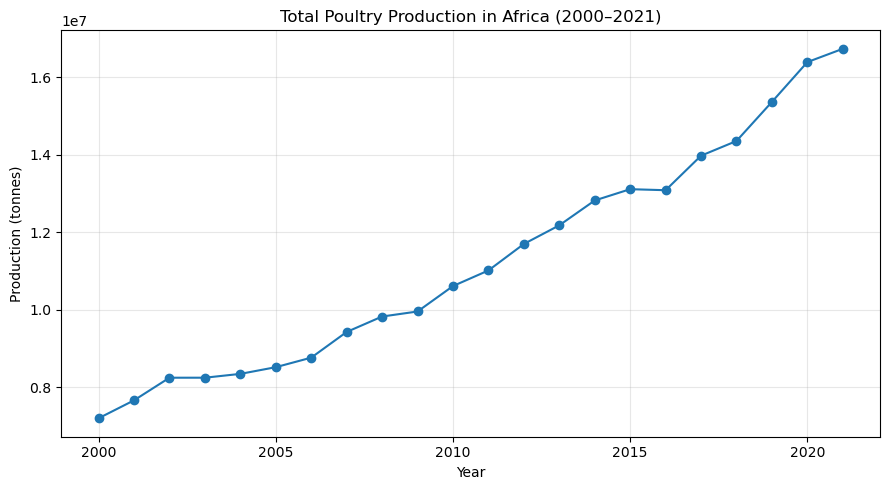

In [37]:
prod_africa_total = (
    prod.groupby("Year", as_index=False)["Production_tonnes"]
        .sum()
        .sort_values("Year")
)

plt.figure(figsize=(9, 5))
plt.plot(prod_africa_total["Year"], prod_africa_total["Production_tonnes"], marker="o")
plt.title("Total Poultry Production in Africa (2000–2021)")
plt.xlabel("Year")
plt.ylabel("Production (tonnes)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Production has shown a consistent upward trend since **2000**, reflecting both rising consumer demand and structural expansion in poultry farming. The lag in 2015-2016 suggests policy shifts or input cost changes.

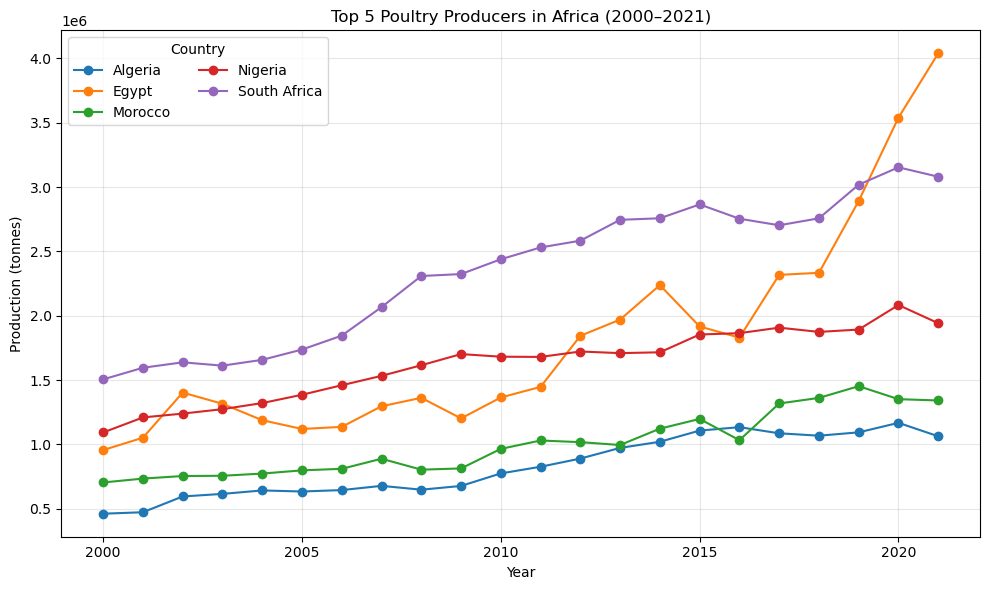

In [38]:
# Top 5 producers by total production over the whole period
prod_top5_countries = (
    prod.groupby("Area")["Production_tonnes"].sum()
        .sort_values(ascending=False)
        .head(5)
        .index.tolist()
)

prod_top5 = prod[prod["Area"].isin(prod_top5_countries)]

# Aggregated by country & year
prod_top5_yearly = (
    prod_top5.groupby(["Area", "Year"], as_index=False)["Production_tonnes"]
        .sum()
        .sort_values(["Area", "Year"])
)

plt.figure(figsize=(10, 6))
for country, grp in prod_top5_yearly.groupby("Area"):
    plt.plot(grp["Year"], grp["Production_tonnes"], marker="o", label=country)

plt.title("Top 5 Poultry Producers in Africa (2000–2021)")
plt.xlabel("Year")
plt.ylabel("Production (tonnes)")
plt.legend(title="Country", loc="upper left", ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**South Africa, Egypt and Nigeria** dominate Africa's poultry production from the year 2000 to 2021, with Egypt showing a steady growth although filled with fluctuations and notable peaks in **2003,2014 and 2021** possibly due to shocks.

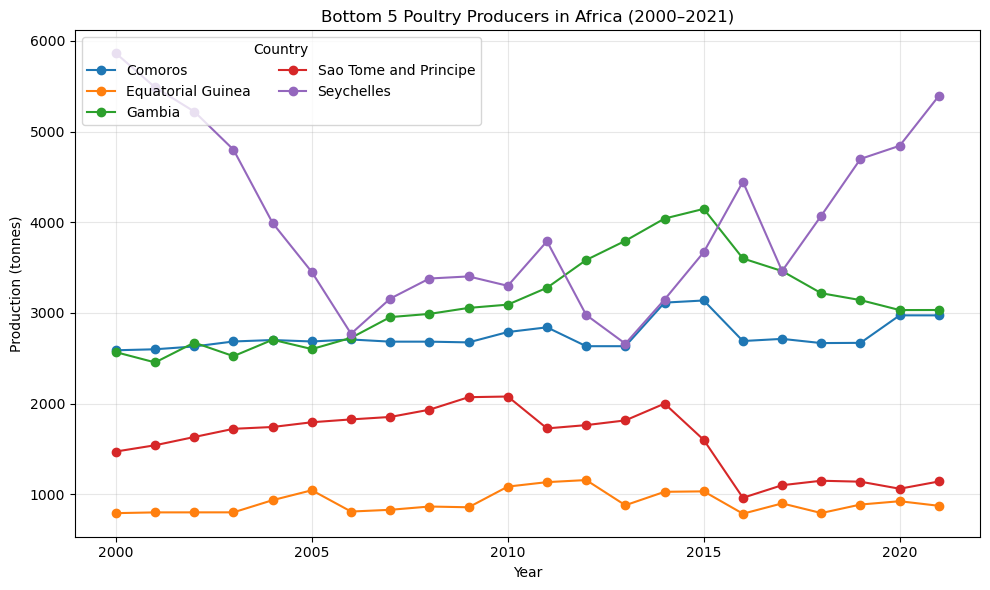

In [39]:
# Bottom 5 producers by total production over the whole period
prod_bottom5_countries = (
    prod.groupby("Area")["Production_tonnes"].sum()
        .sort_values(ascending=True)
        .head(5)
        .index.tolist()
)

prod_bottom5 = prod[prod["Area"].isin(prod_bottom5_countries)]

# Aggregated by country & year
prod_bottom5_yearly = (
    prod_bottom5.groupby(["Area", "Year"], as_index=False)["Production_tonnes"]
        .sum()
        .sort_values(["Area", "Year"])
)

plt.figure(figsize=(10, 6))
for country, grp in prod_bottom5_yearly.groupby("Area"):
    plt.plot(grp["Year"], grp["Production_tonnes"], marker="o", label=country)

plt.title("Bottom 5 Poultry Producers in Africa (2000–2021)")
plt.xlabel("Year")
plt.ylabel("Production (tonnes)")
plt.legend(title="Country", loc="upper left", ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The lowest producers of poultry products include **Equitorial Guinea, Sao Tome and Principe and Comoros** maybe due to the fact that these are small countries with low population signaling low demand for poultry products.

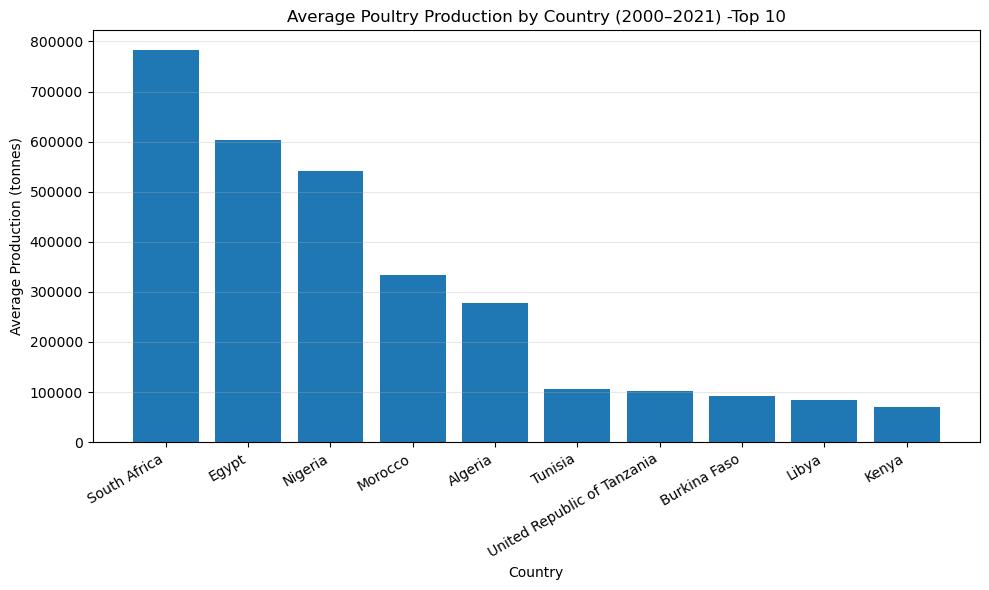

In [40]:
# Average production per country (across years)
prod_country_avg = (
    prod.groupby("Area", as_index=False)["Production_tonnes"]
        .mean()
        .rename(columns={"Production_tonnes": "avg_production_tonnes"})
)

prod_top10_avg = (
    prod_country_avg.sort_values("avg_production_tonnes", ascending=False)
               .head(10)
)

plt.figure(figsize=(10, 6))
plt.bar(prod_top10_avg["Area"], prod_top10_avg["avg_production_tonnes"])
plt.title("Average Poultry Production by Country (2000–2021) -Top 10")
plt.xlabel("Country")
plt.ylabel("Average Production (tonnes)")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


Nigeria, South Africa and Egypt dominate output, concentrating supply in a few markets and exposing regional supply risk.
On the other hand, countries like **Kenya and Libya** faster growth from a smaller base signals catch-up potential.

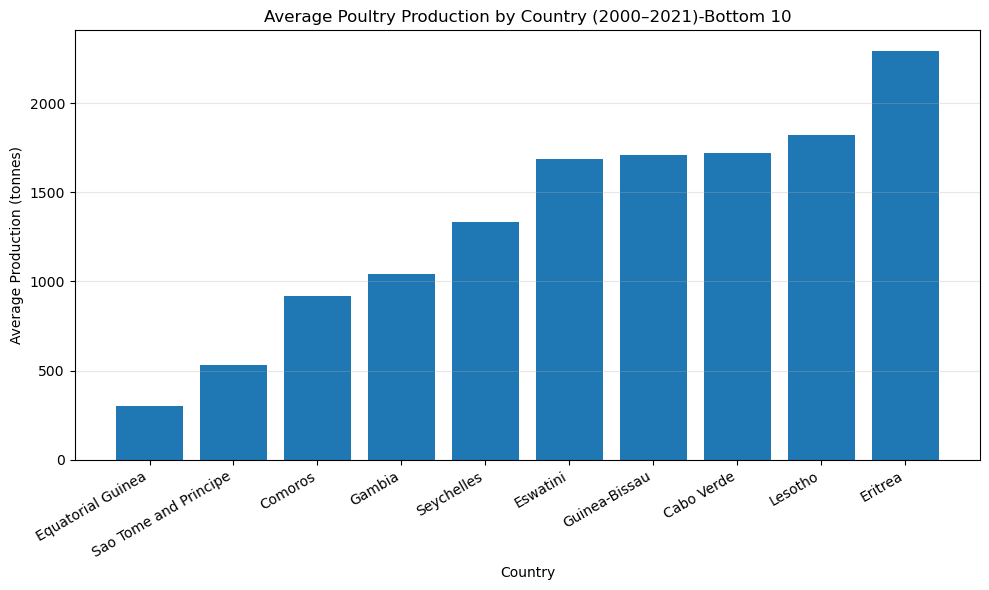

In [41]:
prod_bottom10_avg = (
    prod_country_avg.sort_values("avg_production_tonnes", ascending=True)
               .head(10)
)

plt.figure(figsize=(10, 6))
plt.bar(prod_bottom10_avg["Area"], prod_bottom10_avg["avg_production_tonnes"])
plt.title("Average Poultry Production by Country (2000–2021)-Bottom 10")
plt.xlabel("Country")
plt.ylabel("Average Production (tonnes)")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

The low producer countries signal lower demand for poultry products and also highlights structural under-investment in the sector.

# Prices Dataset Trends and Comparisons

In [42]:
price = pd.read_csv("prices_clean.csv") 

price = price.rename(columns={"Value": "Price(USD/tonne)"})

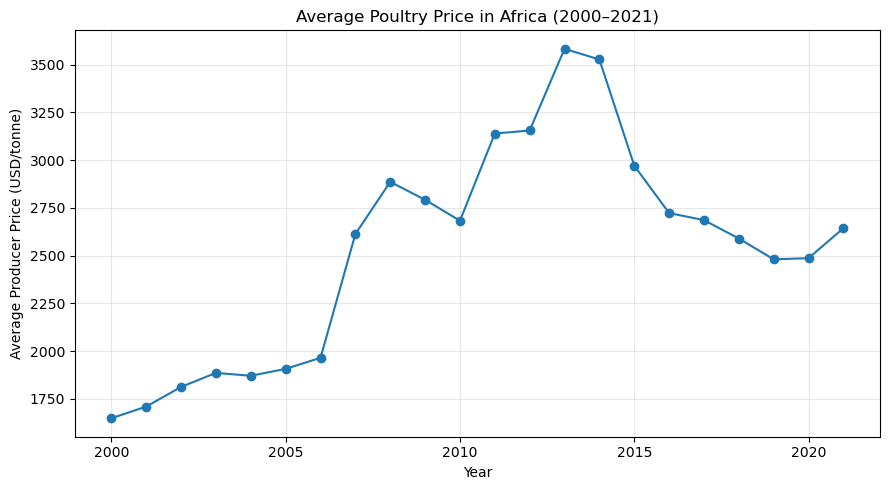

In [43]:
price_africa_avg = (
    price.groupby("Year", as_index=False)["Price(USD/tonne)"]
         .mean()
         .rename(columns={"Price(USD/tonne)": "avg_price(USD/tonne)"})
)

plt.figure(figsize=(9, 5))
plt.plot(price_africa_avg["Year"], price_africa_avg["avg_price(USD/tonne)"], marker="o")
plt.title("Average Poultry Price in Africa (2000–2021)")
plt.xlabel("Year")
plt.ylabel("Average Producer Price (USD/tonne)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Price volatility over the years likely reflect shocks in feed markets and disease outbreaks, underlining sector vulnerability. The volatility reinforces the need for risk-mitigation tools (insurance, finance) to stabilize farmer returns.
There was a notable peak in **2013** but the price reduced significantly afterwards.

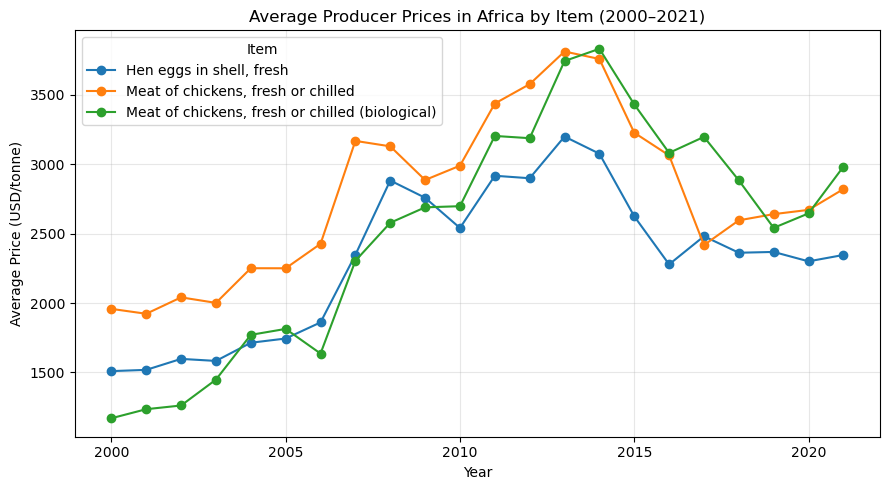

In [44]:
min_years = 5
coverage = price.groupby("Area")["Year"].nunique().reset_index(name="n_years")
valid_areas = coverage.query("n_years >= @min_years")["Area"]
price_valid = price[price["Area"].isin(valid_areas)].copy()

# Grouped by Year + Item to get per-item Africa averages
price_africa_item_avg = (
    price_valid.groupby(["Year", "Item"], as_index=False)["Price(USD/tonne)"]
               .mean()
               .rename(columns={"Price(USD/tonne)": "avg_price(USD/tonne)"})
)

# Plotted per-item trends (eggs vs chicken meat)
plt.figure(figsize=(9, 5))
for item, grp in price_africa_item_avg.groupby("Item"):
    plt.plot(grp["Year"], grp["avg_price(USD/tonne)"], marker="o", label=item)

plt.title("Average Producer Prices in Africa by Item (2000–2021)")
plt.xlabel("Year")
plt.ylabel("Average Price (USD/tonne)")
plt.legend(title="Item")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


The plot above paints a clear picture that chicken meat is consumed in larger quantities than eggs in Africa.

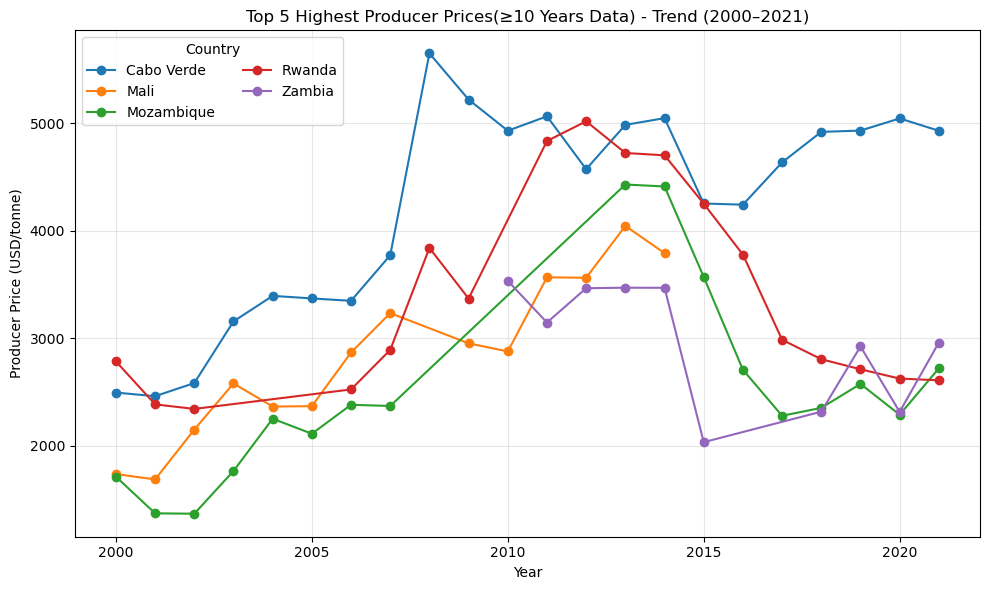

In [45]:
# Count of how many years of data each country has
coverage = (
    price_valid.groupby("Area")["Year"].nunique()
    .reset_index(name="n_years")
)

# Kept only countries with at least 10 years of data
valid_areas = coverage.query("n_years >= 10")["Area"]

# Filtered dataset
price_valid_filtered = price_valid[price_valid["Area"].isin(valid_areas)]


price_country_avg = (
    price_valid_filtered.groupby("Area", as_index=False)["Price(USD/tonne)"]
               .mean()
               .rename(columns={"Price(USD/tonne)": "avg_price(USD/tonne)"})
)
price_top5_countries = (price_country_avg
                        .sort_values("avg_price(USD/tonne)", ascending=False)
                        .head(5)["Area"].tolist())
price_top5 = price_valid_filtered[price_valid_filtered["Area"].isin(price_top5_countries)]

price_top5_yearly = (price_top5.groupby(["Area","Year"], as_index=False)["Price(USD/tonne)"]
               .mean()
               .sort_values(["Area","Year"]))

plt.figure(figsize=(10,6))
for country, grp in price_top5_yearly.groupby("Area"):
    plt.plot(grp["Year"], grp["Price(USD/tonne)"], marker="o", label=country)

plt.title("Top 5 Highest Producer Prices(≥10 Years Data) - Trend (2000–2021)")
plt.xlabel("Year")
plt.ylabel("Producer Price (USD/tonne)")
plt.legend(title="Country", loc="upper left", ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**Cape Verde, Rwanda and Mali** top the list with the highest producer prices with countries like **Zambia and Mali** are also included in the list even though they do not have data for all of the years.
These high prices might be caused by factors such as expensive imported feed, reliance on imported chicks and veterinary supplies and inefficiencies within local supply chains.

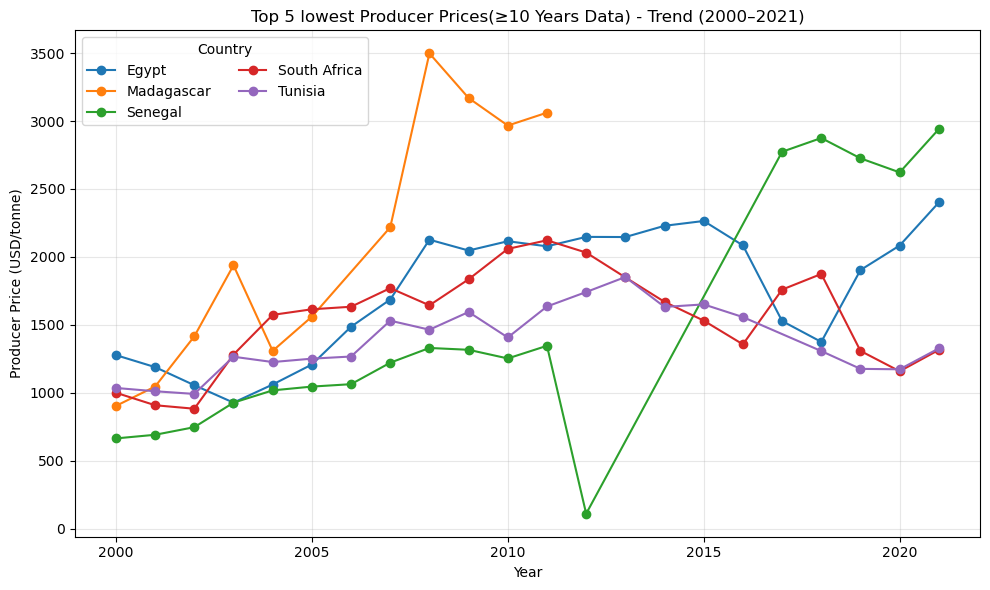

In [46]:
price_bottom5_countries = (price_country_avg 
                        .sort_values("avg_price(USD/tonne)", ascending=True) 
                        .head(5)["Area"].tolist()) 
price_bottom5 = price_valid_filtered[price_valid_filtered["Area"].isin(price_bottom5_countries)] 

price_bottom5_yearly = (price_bottom5.groupby(["Area","Year"], as_index=False)["Price(USD/tonne)"] 
                      .mean() 
                      .sort_values(["Area","Year"])) 

plt.figure(figsize=(10,6)) 
for country, grp in price_bottom5_yearly.groupby("Area"): 
    plt.plot(grp["Year"], grp["Price(USD/tonne)"], marker="o", label=country) 
    
plt.title("Top 5 lowest Producer Prices(≥10 Years Data) - Trend (2000–2021)") 
plt.xlabel("Year") 
plt.ylabel("Producer Price (USD/tonne)") 
plt.legend(title="Country", loc="upper left", ncol=2) 
plt.grid(True, alpha=0.3) 
plt.tight_layout() 
plt.show()

Countries like **Madagascar, Egypt and South Africa** have the lowest producer prices. This suggests that these countries benefit from reduced production costs due to economies of scale, more affordable feed, access to international markets and better infrastructure.

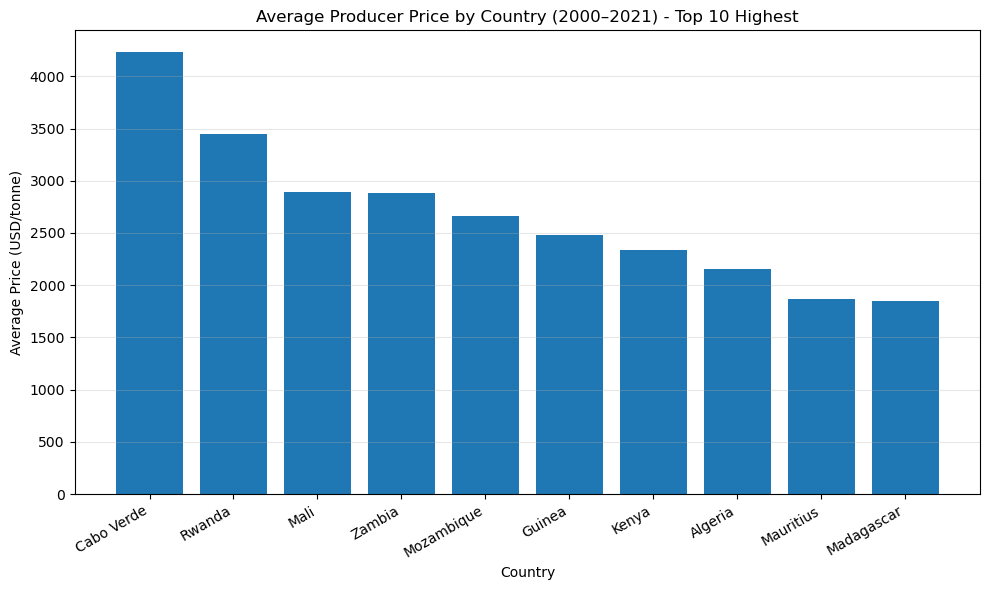

In [47]:
# Top 10 highest average prices
price_top10_high = (price_country_avg.sort_values("avg_price(USD/tonne)", ascending=False).head(10))

plt.figure(figsize=(10,6))
plt.bar(price_top10_high["Area"], price_top10_high["avg_price(USD/tonne)"])
plt.title("Average Producer Price by Country (2000–2021) - Top 10 Highest")
plt.xlabel("Country")
plt.ylabel("Average Price (USD/tonne)")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


Countries with highest producer prices signal high production costs, high import dependency and logistical challenges which should be looked into by policy makers to drive change.

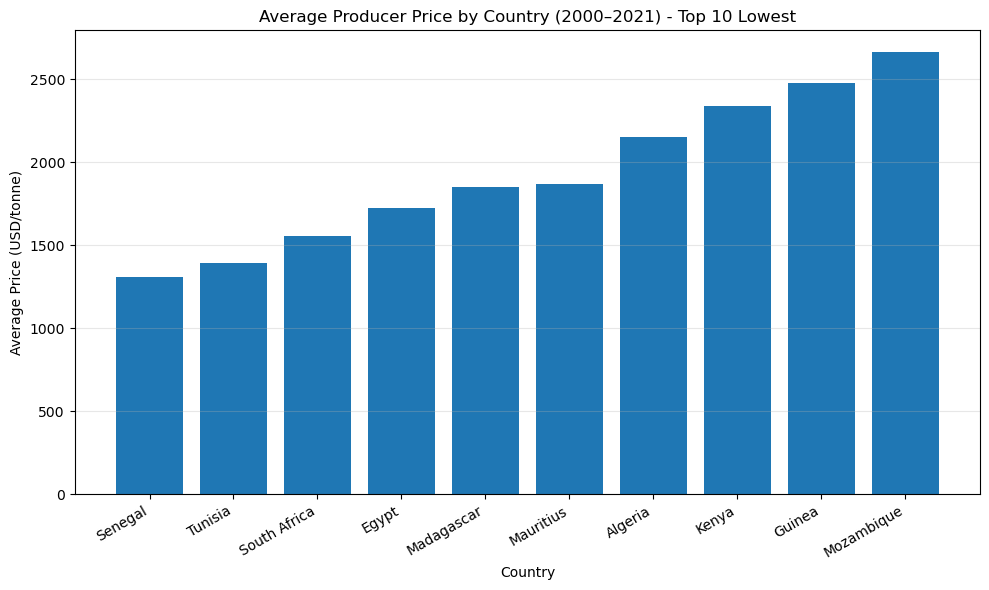

In [48]:
# Top 10 lowest average prices
price_top10_low = (price_country_avg.sort_values("avg_price(USD/tonne)", ascending=True).head(10))

plt.figure(figsize=(10,6))
plt.bar(price_top10_low["Area"], price_top10_low["avg_price(USD/tonne)"])
plt.title("Average Producer Price by Country (2000–2021) - Top 10 Lowest")
plt.xlabel("Country")
plt.ylabel("Average Price (USD/tonne)")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


# Emissions Dataset Trends and Comparisons

In [49]:
emiss = emiss_farm.copy()

emiss = emiss.rename(columns={"Value": "emissions_kt"})

min_years = 10
coverage2 = (emiss.groupby("Area")["Year"].nunique()
            .reset_index(name="n_years"))
valid_areas2 = coverage2.query("n_years >= @min_years")["Area"]
emiss_valid = emiss[emiss["Area"].isin(valid_areas2)].copy()


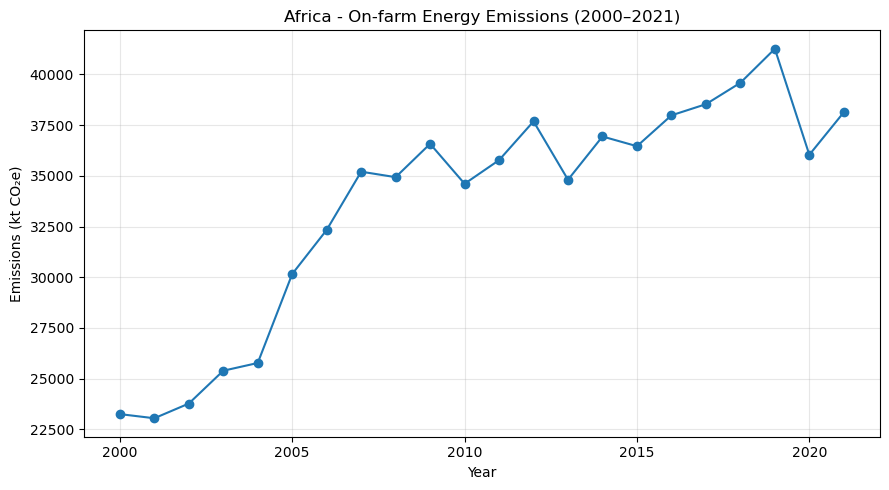

In [50]:
emiss_africa_total = (
    emiss_valid.groupby("Year", as_index=False)["emissions_kt"]
               .sum()
               .sort_values("Year")
)

plt.figure(figsize=(9,5))
plt.plot(emiss_africa_total["Year"], emiss_africa_total["emissions_kt"], marker="o")
plt.title("Africa - On-farm Energy Emissions (2000–2021)")
plt.xlabel("Year")
plt.ylabel("Emissions (kt CO₂e)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Agricultural emissions in Africa have increased over time to meet the agricultural intensification and mechanization which is meant to meet the demands of a growing population. The emissions decreased notably in the period of **2019-2020** due to the severe disruptions caused by the COVID-19 pandemic.

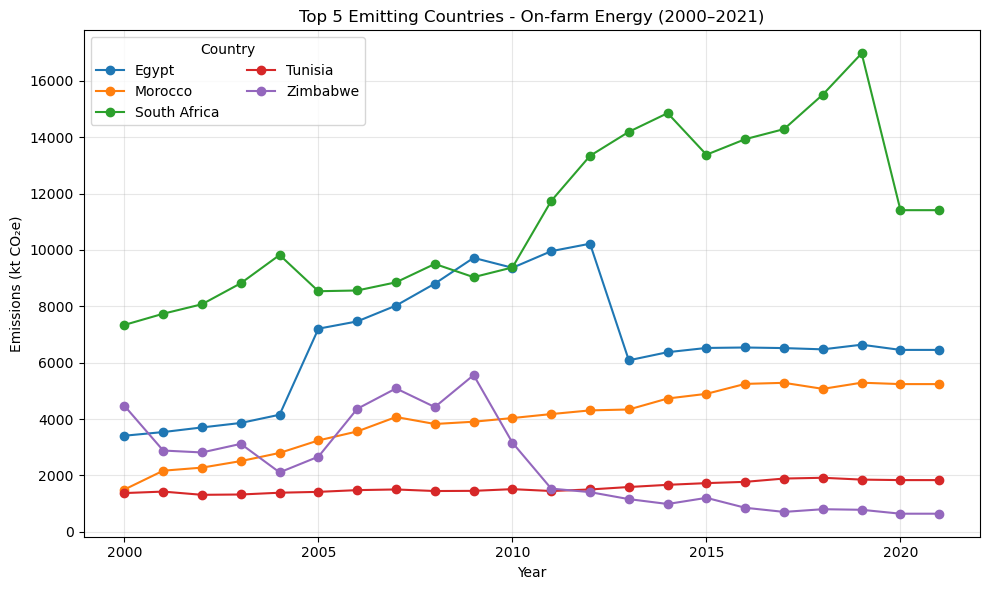

In [51]:
emiss_top5_countries = (
    emiss_valid.groupby("Area", as_index=False)["emissions_kt"].sum()
               .sort_values("emissions_kt", ascending=False)
               .head(5)["Area"].tolist()
)

emiss_top5 = emiss_valid[emiss_valid["Area"].isin(emiss_top5_countries)]

emiss_top5_yearly = (
    emiss_top5.groupby(["Area","Year"], as_index=False)["emissions_kt"]
              .sum()
              .sort_values(["Area","Year"])
)

plt.figure(figsize=(10,6))
for country, grp in emiss_top5_yearly.groupby("Area"):
    plt.plot(grp["Year"], grp["emissions_kt"], marker="o", label=country)

plt.title("Top 5 Emitting Countries - On-farm Energy (2000–2021)")
plt.xlabel("Year")
plt.ylabel("Emissions (kt CO₂e)")
plt.legend(title="Country", loc="upper left", ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Countries like Egypt and South Africa which are high producers of poultry products also contribute a lot to agricultural emissions because the techniques used to boost output often require large amounts of energy and resources and may be a source of high emissions. These countries should invest in sustainable approaches to reduce this. 

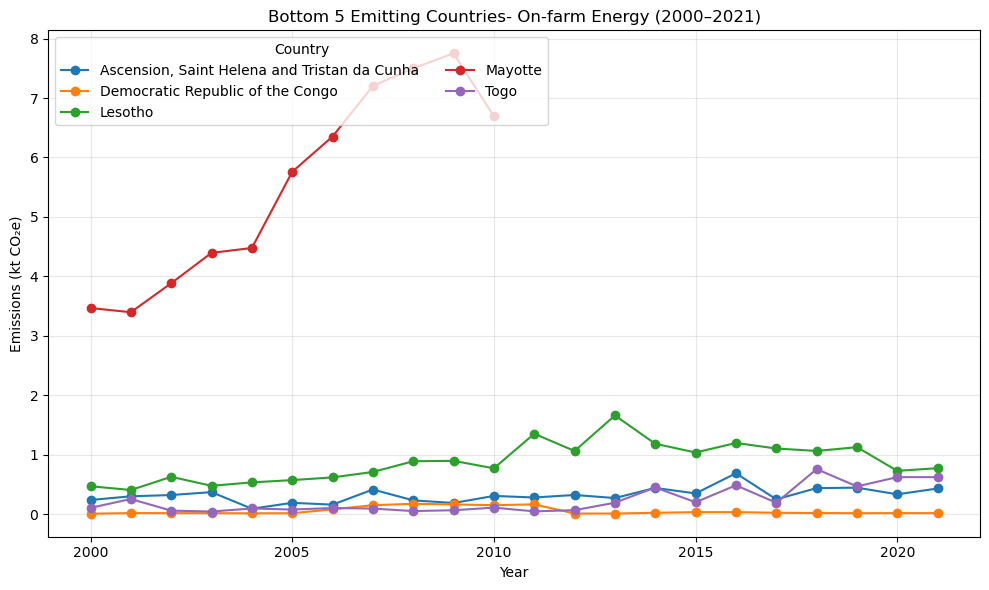

In [52]:
emiss_bottom5_countries = (
    emiss_valid.groupby("Area", as_index=False)["emissions_kt"].sum()
               .sort_values("emissions_kt", ascending=True)
               .head(5)["Area"].tolist()
)

emiss_bottom5 = emiss_valid[emiss_valid["Area"].isin(emiss_bottom5_countries)]

emiss_bottom5_yearly = (
    emiss_bottom5.groupby(["Area","Year"], as_index=False)["emissions_kt"]
                 .sum()
                 .sort_values(["Area","Year"])
)

plt.figure(figsize=(10,6))
for country, grp in emiss_bottom5_yearly.groupby("Area"):
    plt.plot(grp["Year"], grp["emissions_kt"], marker="o", label=country)

plt.title("Bottom 5 Emitting Countries- On-farm Energy (2000–2021)")
plt.xlabel("Year")
plt.ylabel("Emissions (kt CO₂e)")
plt.legend(title="Country", loc="upper left", ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


The countries included above have found efficient ways to increase their output while minimizing their carbon emissions and these efficiency leaders are worth benchmarking.

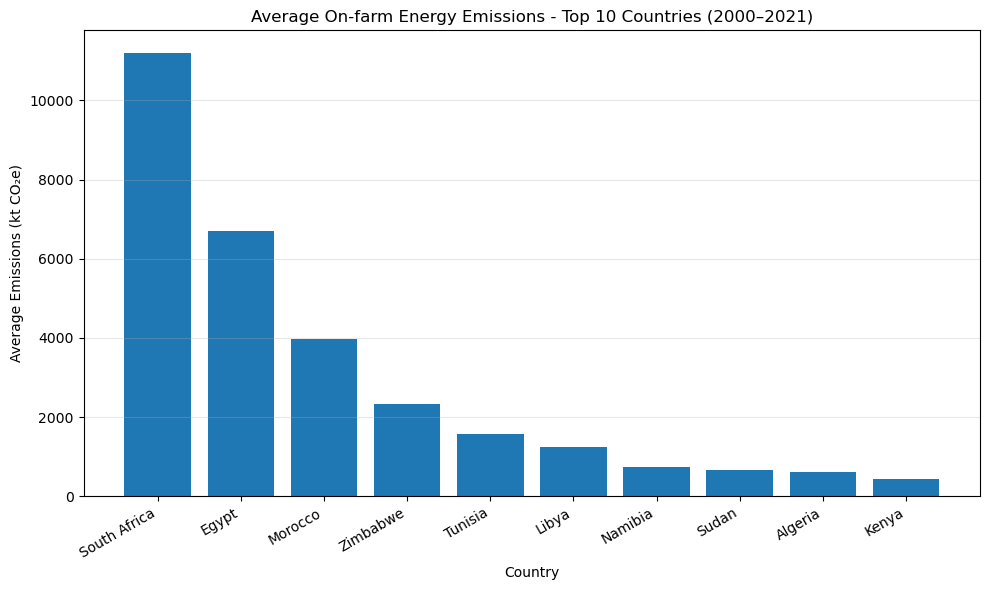

In [53]:
emiss_country_avg = (
    emiss_valid.groupby("Area", as_index=False)["emissions_kt"]
               .mean()
               .rename(columns={"emissions_kt": "avg_emissions_kt"})
)

emiss_top10_avg = emiss_country_avg.sort_values("avg_emissions_kt", ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(emiss_top10_avg["Area"], emiss_top10_avg["avg_emissions_kt"])
plt.title("Average On-farm Energy Emissions - Top 10 Countries (2000–2021)")
plt.xlabel("Country")
plt.ylabel("Average Emissions (kt CO₂e)")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

Countries leading in output are not necessarily efficiency leaders, suggesting scale comes with diminishing sustainability.

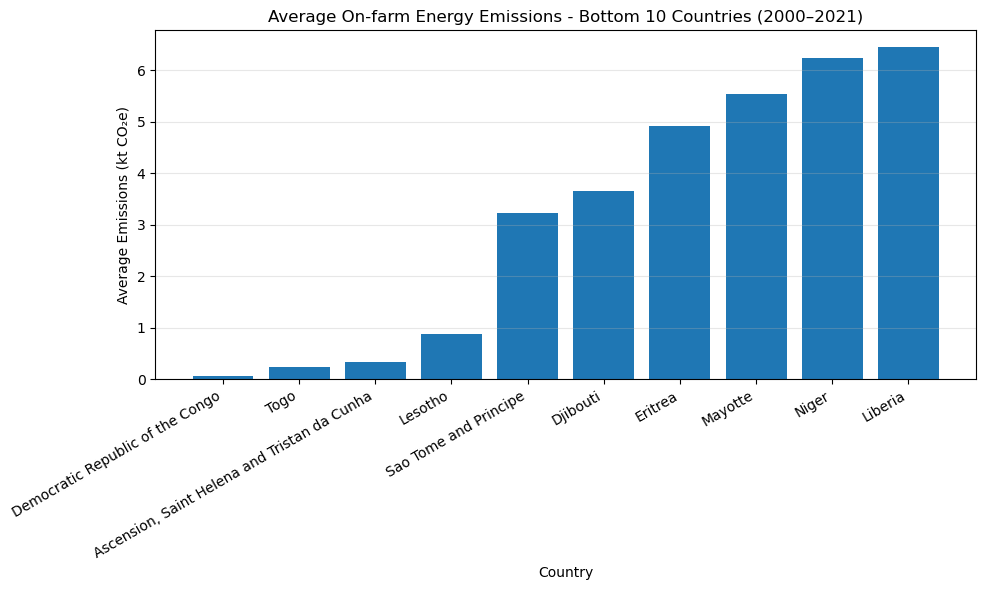

In [54]:
emiss_bottom10_avg = emiss_country_avg.sort_values("avg_emissions_kt", ascending=True).head(10)

plt.figure(figsize=(10,6))
plt.bar(emiss_bottom10_avg["Area"], emiss_bottom10_avg["avg_emissions_kt"])
plt.title("Average On-farm Energy Emissions - Bottom 10 Countries (2000–2021)")
plt.xlabel("Country")
plt.ylabel("Average Emissions (kt CO₂e)")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Relationships Between Datasets

## Production vs Emissions

In [55]:
prod_clean = (prod.groupby(['Area','Year'], as_index=False)
        .agg(production_tonnes=('Production_tonnes','sum')))

emiss_clean = (emiss.groupby(['Area','Year'], as_index=False)
         .agg(emissions_kt=('emissions_kt','sum')))

df = prod_clean.merge(
        emiss_clean,
        on=['Area','Year'],
        how='inner',
        validate='one_to_one'
)

print(df.shape)
print(df.head())


(1144, 4)
      Area  Year  production_tonnes  emissions_kt
0  Algeria  2000           462200.0      190.3146
1  Algeria  2001           473600.0      190.7704
2  Algeria  2002           596200.0      204.1121
3  Algeria  2003           616120.0      214.4583
4  Algeria  2004           643000.0      204.6170


Raw correlation (all countries, all years): 0.796


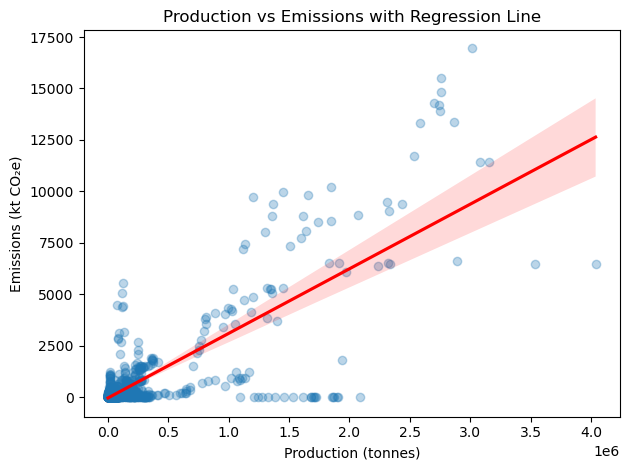

In [56]:
q1 = df[['Area', 'Year', 'production_tonnes', 'emissions_kt']].dropna().copy()

raw_corr = q1[['production_tonnes', 'emissions_kt']].corr().iloc[0,1]
print(f"Raw correlation (all countries, all years): {raw_corr:.3f}")

sns.regplot(
    data=q1, x='production_tonnes', y='emissions_kt',
    scatter_kws={'alpha': 0.3}, line_kws={'color':'red'}
)
plt.xlabel("Production (tonnes)")
plt.ylabel("Emissions (kt CO₂e)")
plt.title("Production vs Emissions with Regression Line")
plt.tight_layout()
plt.show()

Growth comes with an environmental cost ie bigger production is largely associated with bigger emissions but this figure may be exaggerated due to the size effect.

In [57]:
# Deviation from each country's mean
q1['prod_dev'] = q1['production_tonnes'] - q1.groupby('Area')['production_tonnes'].transform('mean')
q1['emis_dev'] = q1['emissions_kt'] - q1.groupby('Area')['emissions_kt'].transform('mean')

within_corr = q1[['prod_dev','emis_dev']].corr().iloc[0,1]
print(f"Within-country correlation: {within_corr:.3f}")


Within-country correlation: 0.367


After controlling for each country’s average size, we see that when a country produces more than its usual level, its emissions also tend to rise above its usual level. But the weaker within-country correlation hints at efficiency gains where some countries manage to expand output without proportionally increasing emissions.

In [58]:
data = q1[['production_tonnes','emissions_kt']].dropna()

slope,intercept = np.polyfit(data['production_tonnes'], data['emissions_kt'], 1)
r = np.corrcoef(data['production_tonnes'], data['emissions_kt'])[0,1]
r2 = r**2

print(f"Intercept: {intercept:.3f}")
print(f"Slope : {slope:.6f}")
print(f"R²: {r2:.3f}")

Intercept: -33.462
Slope : 0.003137
R²: 0.634


The regression suggests agric emissions rise by 0.003 kt CO₂ per extra tonne of poultry. Production explains 63% of emissions variation but efficiency differences account for the rest.

In [59]:
q1['emiss_kg'] = q1['emissions_kt'] * 1_000_000
q1['intensity_kg_per_t'] = q1['emiss_kg'] / q1['production_tonnes']  # How much CO₂ per product?(lower is better)
q1['efficiency_t_per_kt'] = q1['production_tonnes'] / q1['emissions_kt'] # How much product per emissions?(higher is better)

q1[['Area','Year','production_tonnes','emissions_kt','intensity_kg_per_t','efficiency_t_per_kt']].head()

,Area,Year,production_tonnes,emissions_kt,intensity_kg_per_t,efficiency_t_per_kt
0,Algeria,2000,462200.0,190.3146,411.758113,2428.610312
1,Algeria,2001,473600.0,190.7704,402.809122,2482.565429
2,Algeria,2002,596200.0,204.1121,342.355082,2920.943932
3,Algeria,2003,616120.0,214.4583,348.078783,2872.912823
4,Algeria,2004,643000.0,204.6170,318.222395,3142.456394


## Prices vs Production

In [60]:
price_clean = (price.groupby(['Area','Year'], as_index=False)
         .agg(price_usd_per_tonne=('Price(USD/tonne)','mean')))

df = df.merge(
    price_clean,
    on=['Area','Year'],
    how='left',   
    validate='one_to_one'
)
print(df.head())

      Area  Year  production_tonnes  emissions_kt  price_usd_per_tonne
0  Algeria  2000           462200.0      190.3146              1767.20
1  Algeria  2001           473600.0      190.7704              1165.60
2  Algeria  2002           596200.0      204.1121              1487.15
3  Algeria  2003           616120.0      214.4583              1873.50
4  Algeria  2004           643000.0      204.6170              1880.35


Raw correlation (same year, all data): -0.304


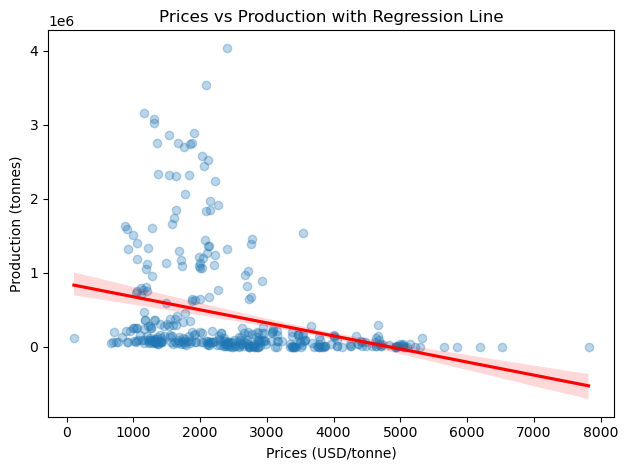

In [61]:
q2 = df[['Area','Year','production_tonnes','price_usd_per_tonne']].dropna().copy()

raw_corr = q2[['production_tonnes','price_usd_per_tonne']].corr().iloc[0,1]
print(f"Raw correlation (same year, all data): {raw_corr:.3f}")

sns.regplot(
    data=q2, x='price_usd_per_tonne', y='production_tonnes',
    scatter_kws={'alpha': 0.3}, line_kws={'color':'red'}
)
plt.xlabel("Prices (USD/tonne)")
plt.ylabel("Production (tonnes)")
plt.title("Prices vs Production with Regression Line")
plt.tight_layout()
plt.show()

Same-year correlation between production and prices is weakly negative (–0.304). This aligns with the downward slope in the scatterplot meaning higher output often coincides with lower prices, though many other factors also drive price movements.

In [62]:
q2 = q2.sort_values(['Area','Year'])

# Price (t) - Production (t+1)
q2['prod_next'] = q2.groupby('Area')['production_tonnes'].shift(-1)
corr_price_to_prod = q2[['price_usd_per_tonne','prod_next']].corr().iloc[0,1]

# Production (t) - Price (t+1)
q2['price_next'] = q2.groupby('Area')['price_usd_per_tonne'].shift(-1)
corr_prod_to_price = q2[['production_tonnes','price_next']].corr().iloc[0,1]

print(f"Correlation: Price(t) - Prod(t+1) = {corr_price_to_prod:.3f}")
print(f"Correlation: Prod(t) - Price(t+1) = {corr_prod_to_price:.3f}")


Correlation: Price(t) - Prod(t+1) = -0.301
Correlation: Prod(t) - Price(t+1) = -0.325


Lagged correlations are weakly negative therefore higher prices don’t consistently translate into more production the next year, but when production rises, next year’s prices tend to ease down ie more supply equals to lower prices.

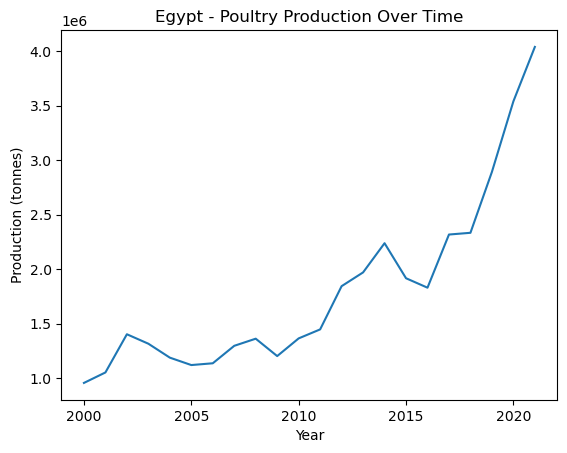

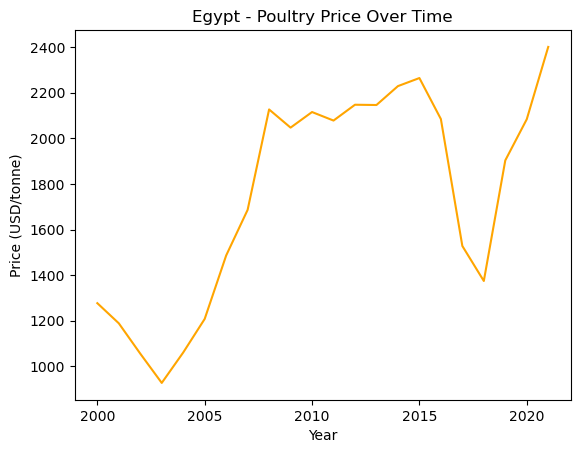

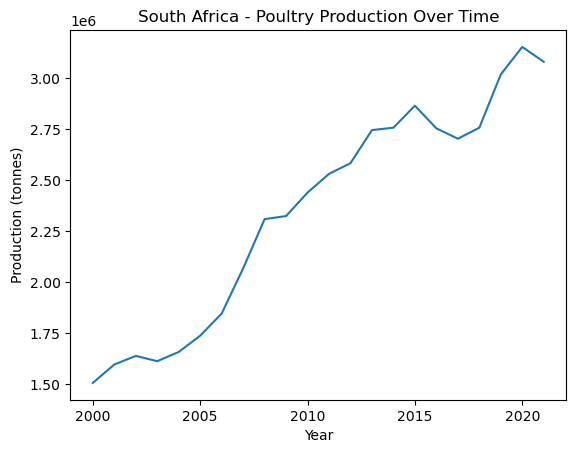

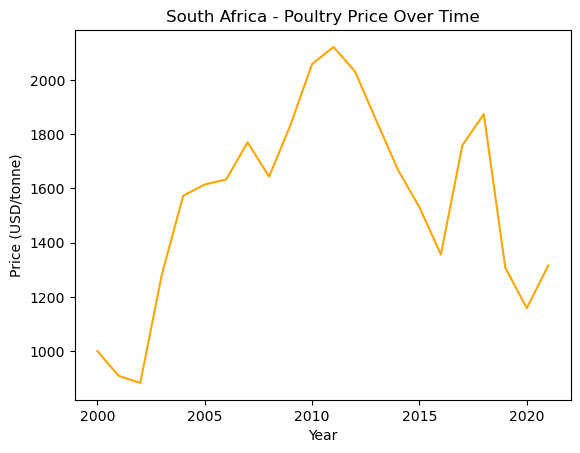

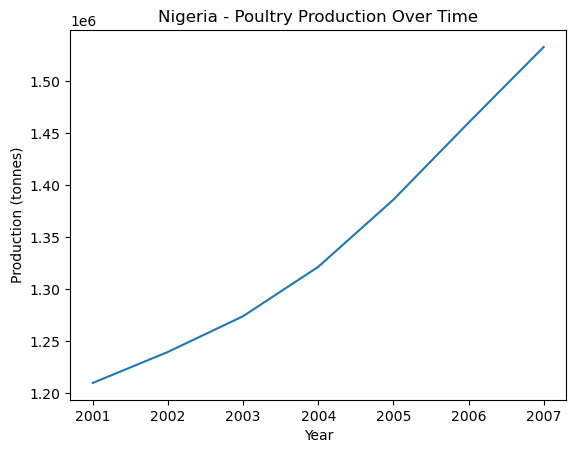

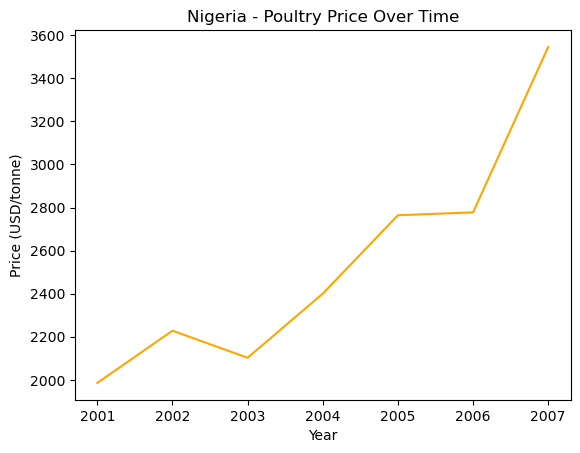

In [63]:
big_countries = ['Egypt','South Africa','Nigeria']

for country in big_countries:
    subset = q2[q2['Area'] == country]
    plt.plot(subset['Year'], subset['production_tonnes'], label='Production (t)')
    plt.xlabel("Year"); plt.ylabel("Production (tonnes)")
    plt.title(f"{country} - Poultry Production Over Time")
    plt.show()

    plt.plot(subset['Year'], subset['price_usd_per_tonne'], label='Price (USD/tonne)', color='orange')
    plt.xlabel("Year"); plt.ylabel("Price (USD/tonne)")
    plt.title(f"{country} - Poultry Price Over Time")
    plt.show()


These plots suggest that for the big poultry producers(**Egypt, South Africa and Nigeria**), as their production increases, prices also tend to increase overtime.

## Efficiency Rankings(Emissions per production output)

In [64]:
q3 = df[['Area','Year','production_tonnes','emissions_kt']].dropna().copy()

# Efficiency metrics
q3['emiss_kg'] = q3['emissions_kt'] * 1_000_000
q3['intensity_kg_per_t'] = q3['emiss_kg'] / q3['production_tonnes']        # lower = better
q3['efficiency_t_per_kt'] = q3['production_tonnes'] / q3['emissions_kt']   # higher = better

q3.replace([float('inf'), float('-inf')], np.nan, inplace=True)
q3.dropna(subset=['efficiency_t_per_kt', 'intensity_kg_per_t'], inplace=True)


In [65]:
ref_year = q3['Year'].max()

ranked = (q3[q3['Year'] == ref_year]
          .loc[:, ['Area','efficiency_t_per_kt','intensity_kg_per_t','production_tonnes','emissions_kt']]
          .sort_values('efficiency_t_per_kt', ascending=False))

top10    = ranked.head(10)
bottom10 = ranked.tail(10)

print(f"Reference year for efficiency ranking: {ref_year}\n")

print("Top 10 countries (most efficient):")
display(top10[['Area','efficiency_t_per_kt']]
        .rename(columns={'efficiency_t_per_kt':'t per kt CO₂'}))

print("\nBottom 10 countries (least efficient):")
display(bottom10[['Area','efficiency_t_per_kt']]
        .rename(columns={'efficiency_t_per_kt':'t per kt CO₂'}))


Reference year for efficiency ranking: 2021

Top 10 countries (most efficient):


,Area,t per kt CO₂
290,Democratic Republic of the Congo,2.014478e+06
1033,Togo,1.217726e+05
109,Burkina Faso,2.274517e+04
175,Cameroon,1.856385e+04
43,Angola,1.841455e+04
620,Madagascar,6.708933e+03
796,Niger,6.418685e+03
554,Lesotho,4.714145e+03
1099,United Republic of Tanzania,4.416395e+03
708,Mauritius,3.822931e+03



Bottom 10 countries (least efficient):


,Area,t per kt CO₂
999,Sudan,141.382260
510,Guinea-Bissau,107.888378
219,Chad,101.473603
686,Mauritania,95.487954
246,Congo,73.431864
444,Gambia,36.127106
87,Botswana,30.660460
378,Eswatini,26.616803
774,Namibia,19.359711
334,Equatorial Guinea,6.840237


Countries like **DRC** and **Togo** top the 2021 efficiency rankings showing that these countries are able to achieve more output with fewer agricultural emissions. **Sudan** and **Guinea-Bissau** are among the least efficient implying that they should reduce their carbon footprint and work towards a more sustainable future by investing in more efficient agricultural methods.

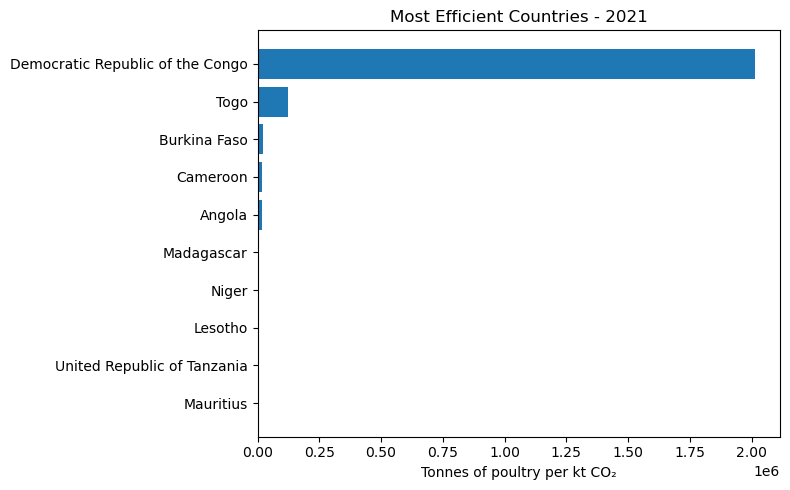

In [66]:
plt.figure(figsize=(8,5))
plt.barh(top10['Area'], top10['efficiency_t_per_kt'])
plt.gca().invert_yaxis()
plt.xlabel('Tonnes of poultry per kt CO₂')
plt.title(f'Most Efficient Countries - {ref_year}')
plt.tight_layout(); plt.show()

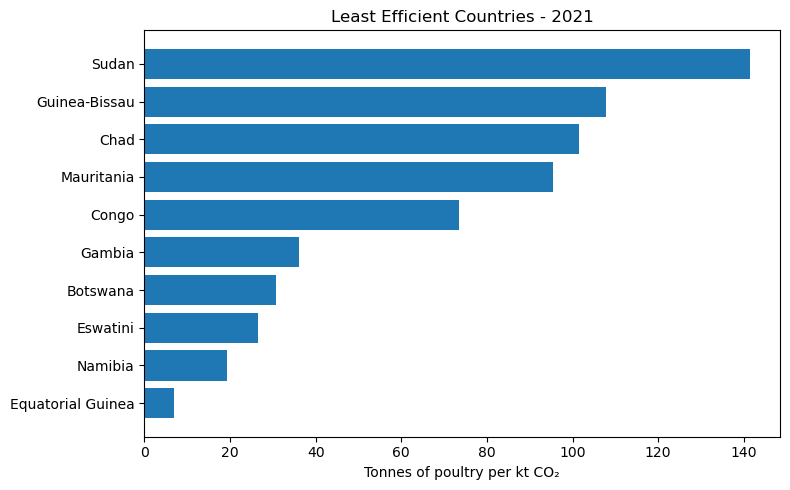

In [67]:
plt.figure(figsize=(8,5))
plt.barh(bottom10['Area'], bottom10['efficiency_t_per_kt'])
plt.gca().invert_yaxis()
plt.xlabel('Tonnes of poultry per kt CO₂')
plt.title(f'Least Efficient Countries - {ref_year}')
plt.tight_layout(); plt.show()

# Analysis Implications
- **Agribusiness:** Growth is concentrated in a few markets.
    - For investors and companies, this concentration means there is a clear opportunity to scale in large markets, but also a risk if one major producer faces shocks (disease outbreak, feed crisis, policy shifts), regional supply and prices can be destabilized.  
- **Policy:** Some countries produce far more poultry per unit of CO₂ than others(efficiency leaders vs laggards).
    - Policymakers can use these efficiency benchmarks to guide technology transfer and support for lagging countries.
- **ESG:** Raw correlations show that big producers emit more simply because of size, but efficiency rankings reveal wide differences in emissions per unit of output.
    - Sustainability reporting should highlight efficiency gaps ie which countries or firms deliver more output per unit of CO₂, not just production volumes.

# Next Steps
- Refine with poultry-specific emission inventories if available.  
- Explore **per-capita consumption** and trade dynamics.  
- Extend to other livestock sectors for a broader food systems view.

# Author
## Naomi Wanjiru